In [131]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from keras.preprocessing import image_dataset_from_directory

from tensorflow import keras
from tensorflow.keras import layers


In [105]:
image_size = [128, 128]
batch_size = 64

In [98]:
train_path = 'chest_xray/train/'
test_path = 'chest_xray/test/'
val_path = 'chest_xray/val/'

In [106]:
ds_train = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
)

ds_test = image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
)

ds_val = image_dataset_from_directory(
    val_path,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
)


Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [107]:
# Combine train, test, and validation sets into one dataset
full_dataset = ds_train.concatenate(ds_test).concatenate(ds_val)

print(f"Full dataset size: {tf.data.experimental.cardinality(full_dataset).numpy() * batch_size}")


Full dataset size: 5952


In [112]:
# Get total number of batches
total_batches = tf.data.experimental.cardinality(full_dataset).numpy()
train_size = int(0.75 * total_batches)  # 80% for training
val_size = total_batches - train_size  # 20% for validation

# Split the dataset
ds_train = full_dataset.take(train_size)  # First 80% for training
ds_val = full_dataset.skip(train_size)  # Remaining 20% for validation

print(f"Training set: {tf.data.experimental.cardinality(ds_train).numpy() * batch_size}")
print(f"Validation set: {tf.data.experimental.cardinality(ds_val).numpy() * batch_size}")


Training set: 4416
Validation set: 1536


Image shape:  (64, 128, 128, 3)


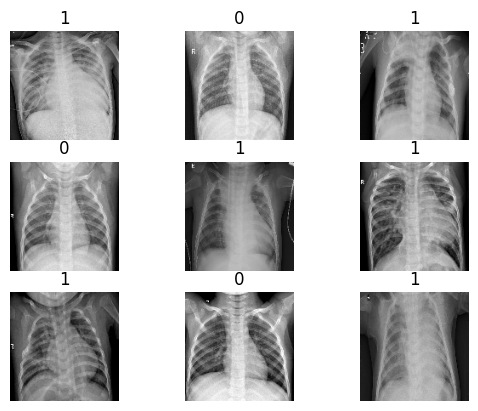

In [114]:
for images, labels in ds_train.take(1):
    print("Image shape: ", images.numpy().shape)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) 
        plt.title(int(labels[i]))
        plt.axis("off")

In [127]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = (
    ds_train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    ds_val
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [142]:
model = keras.Sequential([
    layers.RandomFlip(mode = 'VERTICAL'),

    # Block One
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),

    # Block Two
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.3),

    # Block Three
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.35),

    # Head
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),  # Increased neurons for better learning
    layers.Dropout(0.5),  # 🔹 Dropout before the final layers
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    steps_per_epoch=128 // batch_size,
    epochs=25,
    validation_data=ds_val,
    validation_steps=128 // batch_size,
)


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 22s/step - binary_accuracy: 0.5312 - loss: 0.8575 - val_binary_accuracy: 0.2188 - val_loss: 53.0785
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 11s/step - binary_accuracy: 0.8385 - loss: 0.4644 - val_binary_accuracy: 0.2344 - val_loss: 104.3392
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 13s/step - binary_accuracy: 0.8438 - loss: 0.7279 - val_binary_accuracy: 0.2656 - val_loss: 78.5996
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 11s/step - binary_accuracy: 0.8698 - loss: 0.3288 - val_binary_accuracy: 0.2266 - val_loss: 55.1203
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 11s/step - binary_accuracy: 0.8438 - loss: 0.3740 - val_binary_accuracy: 0.2500 - val_loss: 44.6527
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 11s/step - binary_accuracy: 0.8281 - loss: 0.4448 - val_binary_accuracy: 0.2500 - val_loss: 46.7234
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 11s/step - binary_accuracy: 0.8542 - loss: 0.3174 - val_binary_accuracy: 0.2500 - val_loss: 48.2138
Epoch 8/25
2/2 ━━━━

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 21s/step - binary_accuracy: 0.9219 - loss: 0.2176 - val_binary_accuracy: 0.5156 - val_loss: 0.7257
Epoch 15/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 11s/step - binary_accuracy: 0.9010 - loss: 0.3213 - val_binary_accuracy: 0.6719 - val_loss: 0.5915
Epoch 16/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 11s/step - binary_accuracy: 0.9167 - loss: 0.2098 - val_binary_accuracy: 0.7812 - val_loss: 0.4874
Epoch 17/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 11s/step - binary_accuracy: 0.9062 - loss: 0.2119 - val_binary_accuracy: 0.8203 - val_loss: 0.4379
Epoch 18/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 11s/step - binary_accuracy: 0.8021 - loss: 0.4365 - val_binary_accuracy: 0.8672 - val_loss: 0.3804
Epoch 19/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 11s/step - binary_accuracy: 0.8646 - loss: 0.2013 - val_binary_accuracy: 0.8672 - val_loss: 0.3278
Epoch 20/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 10s/step - binary_accuracy: 0.8750 - loss: 0.2058 - val_binary_accuracy: 0.7396 - val_loss: 0.4920
Epoch 21/25
2/2 ━━━━━━━━━━━━━━━━

In [141]:
history_frame = pd.DataFrame(history.history)


ValueError: All arrays must be of the same length